<a href="https://colab.research.google.com/github/nfilipas/handson-ml3/blob/main/exercises/chapter4/ex12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_iris
from copy import deepcopy
from matplotlib import pyplot as plt

import numpy as np

In [2]:
iris = load_iris(as_frame=True) # load dataset

# get X and y
X = iris.data
y = iris.target

In [3]:
def shuffle_and_split_data(data, test_ratio, seed):
    np.random.seed(seed)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [4]:
# split among training, validation and test sets

seed = 42

X_train_val, X_test = shuffle_and_split_data(X, 0.2, seed)
y_train_val, y_test = shuffle_and_split_data(y, 0.2, seed)

X_train, X_val = shuffle_and_split_data(X_train_val, 0.2, seed)
y_train, y_val = shuffle_and_split_data(y_train_val, 0.2, seed)

In [28]:
def cross_entropy_loss(y_matrix, p_hat_matrix):
    eps = 1e-10 * np.ones(p_hat_matrix.shape)
    m = p_hat_matrix.shape[1]
    return -1/m * np.sum(y_matrix * np.log(p_hat_matrix + eps), axis=None)

def estimated_prob(X_ext, theta):

    # calculate matrix s
    s = theta @ X_ext.T # s has classes on rows, number of instances on columns

    # calculate matrix p_hat
    K = s.shape[0]
    m = s.shape[1]
    p_hat = np.empty(s.shape)
    for c in range(m):
        den = 0
        for k in range(K):
            den += np.exp(s[k, c])
        for k in range(K):
            p_hat[k, c] = np.exp(s[k, c]) / den

    return p_hat

In [54]:
class softmax_regressor:

    def __init__(self):
        self.trained = False

    def train(self, X, y, n_epochs, eta, seed, X_val=None, y_val=None):
        m = len(X) # number of instances
        n = len(X.columns) # number of features
        K = len(np.unique(y)) # number of classes

        # random initialization of matrix theta
        np.random.seed(seed)
        self.theta = np.random.randn(K, n+1)

        # extend X matrix
        X_ext = np.concatenate((np.ones((m, 1)), X), axis=1)

        # calculate y as a matrix
        y_matrix = np.empty((K, m))
        for c in range(m):
            for k in range(K):
                y_matrix[k, c] = y.iloc[c] == k

        self.train_loss = []

        if X_val is not None and y_val is not None:
            m_val = X_val.shape[0]
            X_val_ext = np.concatenate((np.ones((m_val, 1)), X_val), axis=1)

            y_val_matrix = np.empty((K, m_val))
            for c in range(m_val):
                for k in range(K):
                    y_val_matrix[k, c] = y_val.iloc[c] == k

            self.val_loss = []
            self.best_val_loss = float("inf")

        for epoch in range(n_epochs):

            # calculate p_hat matrix
            p_hat = estimated_prob(X_ext, self.theta)

            # calculate train loss
            self.train_loss.append(cross_entropy_loss(y_matrix, p_hat))

            # calculate validation loss if available
            if X_val is not None and y_val is not None:
                p_hat_val = estimated_prob(X_val_ext, self.theta)
                val_loss_current = cross_entropy_loss(y_val_matrix, p_hat_val)
                self.val_loss.append(val_loss_current)

                if val_loss_current < self.best_val_loss:
                    self.best_val_loss = val_loss_current
                    self.best_theta = self.theta
                    self.best_epoch = epoch

            # calculate gradient matrix
            diff_matrix = p_hat - y_matrix

            gradients = np.zeros(self.theta.shape)
            for k in range(K):
                for c in range(m):
                    gradients[k, :] += diff_matrix[k, c] * X_ext[c, :]
            gradients = 1/m*gradients

            # make a step
            self.theta -= eta*gradients

        self.trained = True

    def predict(self, X, best=False):
        if not self.trained:
            raise ValueError("Classifier has not been trained yet.")

        m = len(X)
        X_ext = np.concatenate((np.ones((m, 1)), X), axis=1)
        if best:
            return np.argmax(self.best_theta @ X_ext.T, axis=0)
        else:
            return np.argmax(self.theta @ X_ext.T, axis=0)

    def get_train_loss(self):
        if not self.trained:
            raise ValueError("Classifier has not been trained yet.")
        return self.train_loss

    def get_val_loss(self):
        if not self.trained:
            raise ValueError("Classifier has not been trained yet.")
        if X_val is None or y_val is None:
            raise ValueError("Validation set has not been given.")
        return self.val_loss

    def get_best_epoch(self):
        return self.best_epoch

In [59]:
n_epochs = 10000
eta = 0.1
seed = 42
softmax_clf = softmax_regressor()
softmax_clf.train(X_train, y_train, n_epochs=n_epochs, eta=eta, seed=seed,
                  X_val=X_val, y_val=y_val)
train_loss_all = softmax_clf.get_train_loss()
val_loss_all = softmax_clf.get_val_loss()

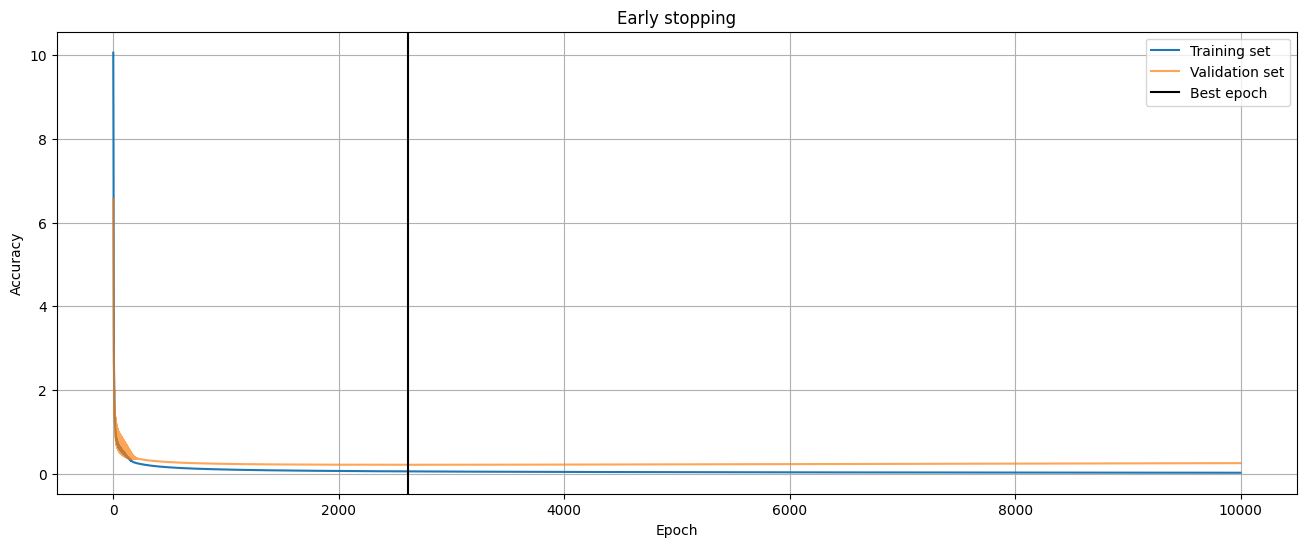

In [66]:
plt.figure(figsize=(16, 6))
plt.plot(range(n_epochs), train_loss_all, label="Training set")
plt.plot(range(n_epochs), val_loss_all, label="Validation set", alpha=0.7)
plt.axvline(softmax_clf.get_best_epoch(), color="black", label="Best epoch")
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Early stopping")
plt.show()

In [69]:
y_test_pred = softmax_clf.predict(X_test, best=True)
accuracy_test = np.sum((y_test - y_test_pred) == 0) / len(y_test)
print(accuracy_test)

0.9666666666666667
